# Mullti-task Learning on Cifar100 Dataset: A CNN Approach
- Name: Minh T. Nguyen, Peter Chen
- ECE 6524 - Final Project
- Date: 4/14/2023
- **Objective**: Build a MTL model for image classification.
    - Task 1: Normal class classification (100 Classes).
    - Task 2: Superclass classification (20 Classes).
    
- **To Do**:
    - Experience with Different Model Configuration: 
        - Optimizers
        - Regularization: Dropout

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
from keras.datasets import cifar100
from keras.utils import np_utils, plot_model
from keras.layers import Input, Dropout, Flatten, Dense
from keras.applications.resnet import ResNet152, preprocess_input
from keras import Model

In [2]:
tf.version.VERSION

'2.11.0'

# 1. Data Visualization & Preprocessing

# 1.1 Data Visualization

In [3]:
# download data from Keras API
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 11s 0us/step


In [4]:
# check dataset size
print(f"X={X_train.shape}, y={y_train.shape}")
print(f"X={X_test.shape}, y={y_test.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


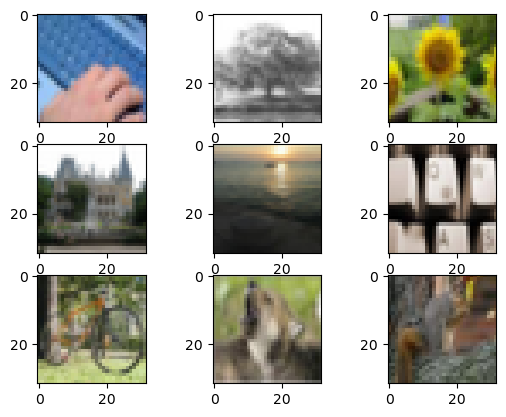

In [5]:
# plot the 9 images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(X_train[10])
axarr[0,1].imshow(X_train[11])
axarr[0,2].imshow(X_train[12])
axarr[1,0].imshow(X_train[13])
axarr[1,1].imshow(X_train[14])
axarr[1,2].imshow(X_train[15])
axarr[2,0].imshow(X_train[16])
axarr[2,1].imshow(X_train[17])
axarr[2,2].imshow(X_train[18])
plt.show()

## 1.2. Creating Superclasses

**Superclass**
* aquatic mammals
* fish
* flowers
* food containers
* fruit and vegetables
* household electrical devices
* household furniture
* insects
* large carnivores
* large man-made outdoor things
* large natural outdoor scenes
* large omnivores and herbivores
* medium-sized mammals
* non-insect invertebrates
* people
* reptiles
* small mammals
* trees
* vehicles 1
* vehicles 2

In [6]:
# generate super-class of CIFAR100 dataset
(X_train_super, y_train_super), (X_test_super, y_test_super) = cifar100.load_data(label_mode = 'coarse')

In [7]:
# check labels for accuracy (referencing image plotted above)
print(y_train_super[10:19])

[[ 5]
 [17]
 [ 2]
 [ 9]
 [10]
 [ 5]
 [18]
 [ 8]
 [16]]


## 1.3. Data Processing

In [8]:
# normalize input data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

# convert class into one hot encoder
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('\ny_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

# convert class into one hot encoder
y_train_super = np_utils.to_categorical(y_train_super)
y_test_super = np_utils.to_categorical(y_test_super)

print('\ny_train_super shape: ', y_train_super.shape)
print('y_test_super shape: ', y_test_super.shape)

X_train shape:  (50000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)

y_train shape:  (50000, 100)
y_test shape:  (10000, 100)

y_train_super shape:  (50000, 20)
y_test_super shape:  (10000, 20)


# 2. Modeling

In [9]:
# Define ResNet152 CNN model
def create_model(dropout):
    input_shape = (32, 32, 3)
    
    resnet152_base = ResNet152(weights=None, include_top=False, input_shape=input_shape)
    
    
    # shared back-bone: convolution - feature extractor
    inputs = Input(shape=input_shape, name='input')
    shared_branch = resnet152_base(inputs)
    shared_branch = Flatten()(shared_branch)
    shared_branch = Dense(2048, activation='relu')(shared_branch)
    
    # task 1 branch - fully connected for 100-class classification
    task_1_branch = Dense(1024, activation='relu')(shared_branch)
    task_1_branch = Dropout(dropout)(task_1_branch) 
    task_1_branch = Dense(512, activation="relu")(task_1_branch)
    task_1_branch = Dense(256, activation="relu")(task_1_branch)
    task_1_branch = Dense(128, activation="relu")(task_1_branch)
    task_1_branch = Dense(100, activation="softmax", name="task_1_output")(task_1_branch)
    
    # task 1 branch - fully connected for 20-class superclass classification
    task_2_branch = Dense(512, activation='relu')(shared_branch)
    task_2_branch = Dropout(dropout)(task_2_branch)
    task_2_branch = Dense(256, activation="relu")(task_2_branch)
    task_2_branch = Dense(128, activation="relu")(task_2_branch)
    task_2_branch = Dense(20, activation="softmax", name="task_2_output")(task_2_branch)
    
    # modeling
    model = Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])
    
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resnet152 (Functional)         (None, 1, 1, 2048)   58370944    ['input[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['resnet152[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 2048)         4196352     ['flatten[0][0]']                
                                                                                              

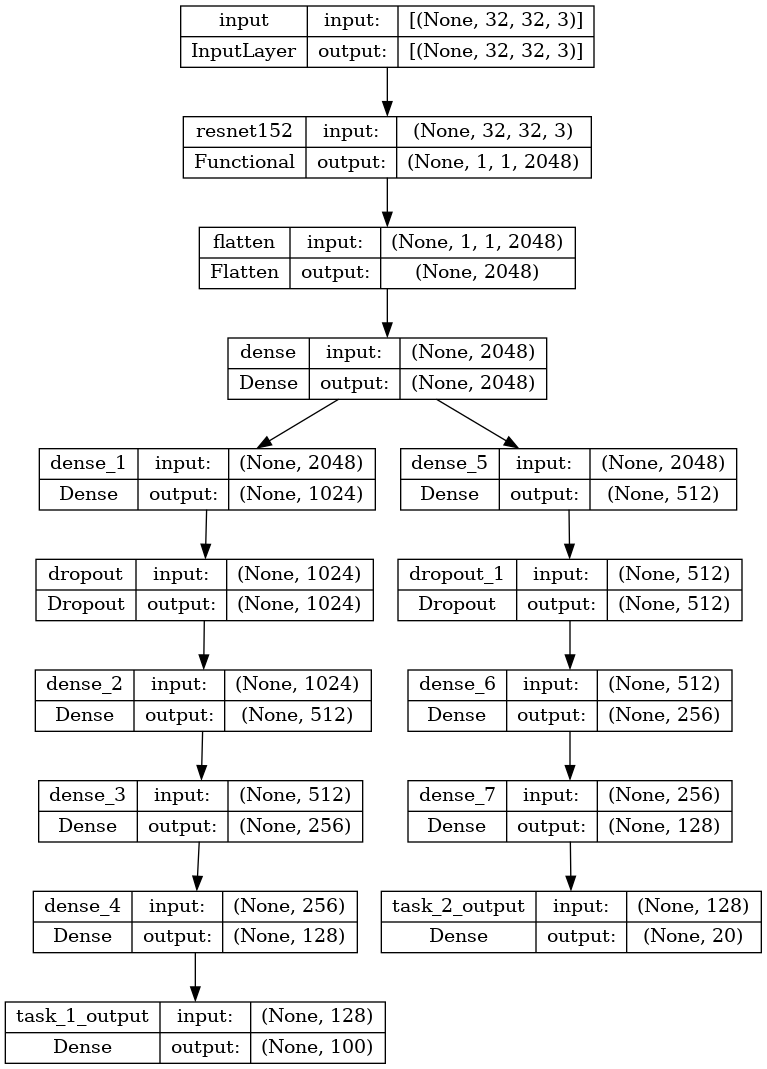

In [10]:
# display and plot model
model = create_model(0)
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# define number of epochs and batch size
epochs = 20
batch_size = 256

## 2.1. Case 1: Gamma = 0.5 - The model will receive the loss evenly in both tasks
##      (Dropout = 0, Optimizer = Adam)

In [12]:
# define parameters and generate model
gamma=0.5
dropout = 0
optimizer = 'Adam'
model_1 = create_model(dropout)

In [13]:
# compile model
model_1.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [14]:
# train model
history_1 = model_1.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 145s 219ms/step - loss: 3.6832 - task_1_output_loss: 4.4689 - task_2_output_loss: 2.8975 - task_1_output_accuracy: 0.0203 - task_2_output_accuracy: 0.0951 - val_loss: 4.0682 - val_task_1_output_loss: 4.9287 - val_task_2_output_loss: 3.2078 - val_task_1_output_accuracy: 0.0103 - val_task_2_output_accuracy: 0.0507
Epoch 2/20
167/167 [==============================] - 33s 196ms/step - loss: 3.4476 - task_1_output_loss: 4.2188 - task_2_output_loss: 2.6764 - task_1_output_accuracy: 0.0314 - task_2_output_accuracy: 0.1365 - val_loss: 3.6527 - val_task_1_output_loss: 4.4303 - val_task_2_output_loss: 2.8752 - val_task_1_output_accuracy: 0.0275 - val_task_2_output_accuracy: 0.1011
Epoch 3/20
167/167 [==============================] - 33s 196ms/step - loss: 3.4140 - task_1_output_loss: 4.1757 - task_2_output_loss: 2.6523 - task_1_output_accuracy: 0.0389 - task_2_output_accuracy: 0.1477 - val_loss: 3.5891 - val_task_1_output_loss: 4.3494 - val

In [15]:
# train model results
print('Train loss:', history_1.history['loss'][-1])

print('\nTrain task 1 loss:', history_1.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_1.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_1.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_1.history['task_2_output_accuracy'][-1])

Train loss: 3.2229907512664795

Train task 1 loss: 3.9428915977478027
Train task 1 acc: 0.06960000097751617

Train task 2 loss: 2.5030887126922607
Train task 2 acc: 0.20319999754428864


### Evaluate Model

In [16]:
# test model results
evaluation_results = model_1.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [17]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 7.215325832366943

Test task 1 loss: 9.22855281829834
Test task 1 acc: 0.021199999377131462

Test task 2 loss: 5.202084541320801
Test task 2 acc: 0.07410000264644623


### Plot Results

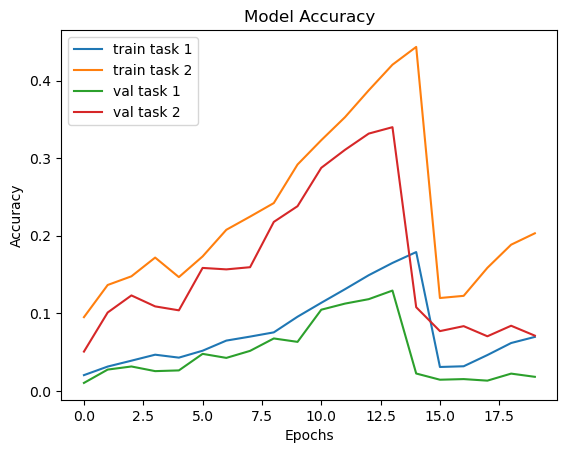

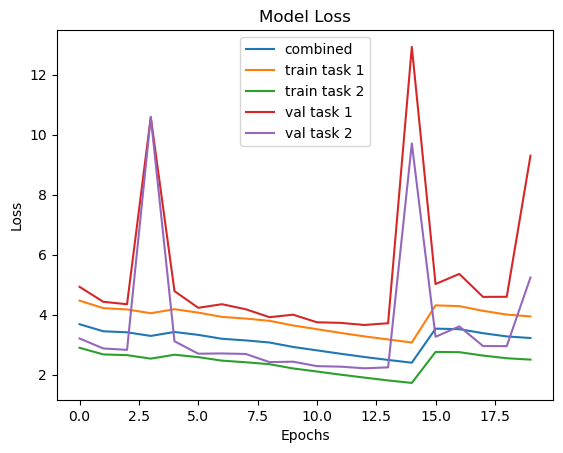

In [18]:
# accuracy plot
plt.plot(history_1.history['task_1_output_accuracy'])
plt.plot(history_1.history['task_2_output_accuracy'])
plt.plot(history_1.history['val_task_1_output_accuracy'])
plt.plot(history_1.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['task_1_output_loss'])
plt.plot(history_1.history['task_2_output_loss'])
plt.plot(history_1.history['val_task_1_output_loss'])
plt.plot(history_1.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.2. Case 2: Gamma = 0.6 - The model will receive loss 60% from task 1, 40% from task 2.
##      (Dropout = 0, Optimizer = Adam)

### Get Model

In [19]:
# define parameters and generate model
gamma=0.6
dropout = 0
optimizer = 'Adam'
model_2 = create_model(dropout)

In [20]:
# compile model
model_2.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [21]:
# train model
history_2 = model_2.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 137s 209ms/step - loss: 3.8839 - task_1_output_loss: 4.5148 - task_2_output_loss: 2.9376 - task_1_output_accuracy: 0.0165 - task_2_output_accuracy: 0.0796 - val_loss: 3.9920 - val_task_1_output_loss: 4.6347 - val_task_2_output_loss: 3.0279 - val_task_1_output_accuracy: 0.0093 - val_task_2_output_accuracy: 0.0500
Epoch 2/20
167/167 [==============================] - 33s 196ms/step - loss: 3.7887 - task_1_output_loss: 4.4147 - task_2_output_loss: 2.8496 - task_1_output_accuracy: 0.0216 - task_2_output_accuracy: 0.0922 - val_loss: 3.8142 - val_task_1_output_loss: 4.4331 - val_task_2_output_loss: 2.8858 - val_task_1_output_accuracy: 0.0228 - val_task_2_output_accuracy: 0.1020
Epoch 3/20
167/167 [==============================] - 33s 195ms/step - loss: 3.6281 - task_1_output_loss: 4.2389 - task_2_output_loss: 2.7118 - task_1_output_accuracy: 0.0332 - task_2_output_accuracy: 0.1279 - val_loss: 3.6972 - val_task_1_output_loss: 4.3329 - val

In [22]:
# train model results
print('Train loss:', history_2.history['loss'][-1])

print('\nTrain task 1 loss:', history_2.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_2.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_2.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_2.history['task_2_output_accuracy'][-1])

Train loss: 2.633528232574463

Train task 1 loss: 3.131744146347046
Train task 1 acc: 0.2035764753818512

Train task 2 loss: 1.8862029314041138
Train task 2 acc: 0.4046117663383484


### Evaluate Model

In [23]:
# test model results
evaluation_results = model_2.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [24]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 2.8274974822998047

Test task 1 loss: 3.3386406898498535
Test task 1 acc: 0.17409999668598175

Test task 2 loss: 2.0607807636260986
Test task 2 acc: 0.3562999963760376


### Plot Results

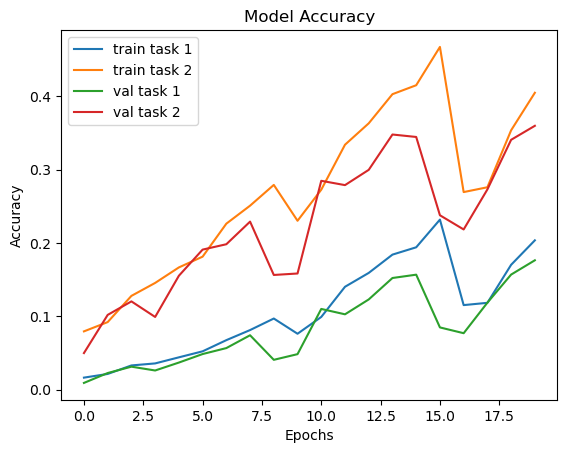

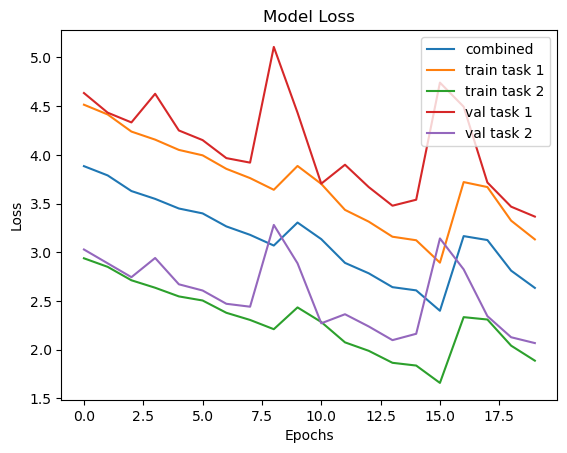

In [25]:
# accuracy plot
plt.plot(history_2.history['task_1_output_accuracy'])
plt.plot(history_2.history['task_2_output_accuracy'])
plt.plot(history_2.history['val_task_1_output_accuracy'])
plt.plot(history_2.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['task_1_output_loss'])
plt.plot(history_2.history['task_2_output_loss'])
plt.plot(history_2.history['val_task_1_output_loss'])
plt.plot(history_2.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.3. Case 3: Gamma = 0.4 - The model will receive loss 40% from task 1, 60% from task 2.
##      (Dropout = 0, Optimizer = Adam)

In [26]:
# define parameters and generate model
gamma=0.4
dropout = 0
optimizer = 'Adam'
model_3 = create_model(dropout)

In [27]:
# compile model
model_3.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [28]:
# train model
history_3 = model_3.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 136s 213ms/step - loss: 3.5565 - task_1_output_loss: 4.5309 - task_2_output_loss: 2.9069 - task_1_output_accuracy: 0.0182 - task_2_output_accuracy: 0.0898 - val_loss: 3.6514 - val_task_1_output_loss: 4.6258 - val_task_2_output_loss: 3.0017 - val_task_1_output_accuracy: 0.0092 - val_task_2_output_accuracy: 0.0592
Epoch 2/20
167/167 [==============================] - 32s 189ms/step - loss: 3.3524 - task_1_output_loss: 4.2775 - task_2_output_loss: 2.7357 - task_1_output_accuracy: 0.0323 - task_2_output_accuracy: 0.1268 - val_loss: 3.4517 - val_task_1_output_loss: 4.4034 - val_task_2_output_loss: 2.8173 - val_task_1_output_accuracy: 0.0287 - val_task_2_output_accuracy: 0.1096
Epoch 3/20
167/167 [==============================] - 32s 190ms/step - loss: 3.2547 - task_1_output_loss: 4.1650 - task_2_output_loss: 2.6479 - task_1_output_accuracy: 0.0404 - task_2_output_accuracy: 0.1518 - val_loss: 3.4701 - val_task_1_output_loss: 4.4165 - val

In [29]:
# train model results
print('Train loss:', history_3.history['loss'][-1])

print('\nTrain task 1 loss:', history_3.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_3.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_3.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_3.history['task_2_output_accuracy'][-1])

Train loss: 2.7576146125793457

Train task 1 loss: 3.5822536945343018
Train task 1 acc: 0.13404706120491028

Train task 2 loss: 2.2078545093536377
Train task 2 acc: 0.3168470561504364


### Evaluate Model

In [30]:
# test model results
evaluation_results = model_3.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [31]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 3.1442551612854004

Test task 1 loss: 4.019529342651367
Test task 1 acc: 0.09719999879598618

Test task 2 loss: 2.560737371444702
Test task 2 acc: 0.2540999948978424


### Plot Results

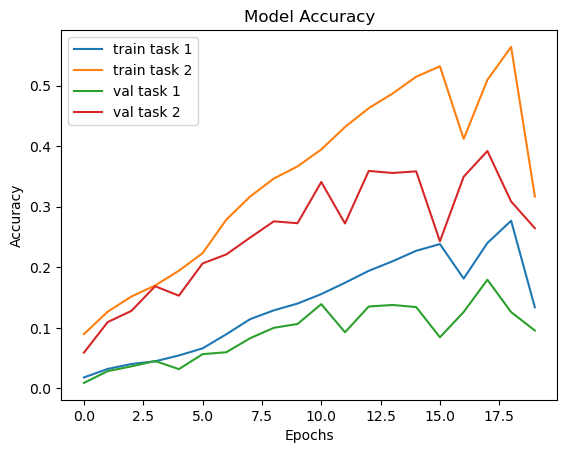

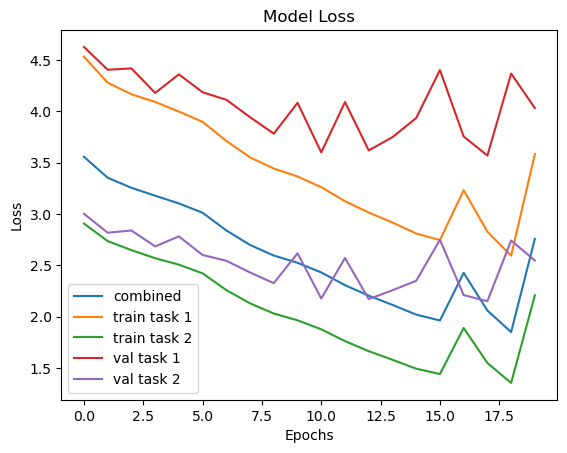

In [32]:
# accuracy plot
plt.plot(history_3.history['task_1_output_accuracy'])
plt.plot(history_3.history['task_2_output_accuracy'])
plt.plot(history_3.history['val_task_1_output_accuracy'])
plt.plot(history_3.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['task_1_output_loss'])
plt.plot(history_3.history['task_2_output_loss'])
plt.plot(history_3.history['val_task_1_output_loss'])
plt.plot(history_3.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.4. Case 4: Gamma = 0.5 - The model will receive loss evenly from task 1 and task 2.
##      (Dropout = 0.5, Optimizer = Adam)

In [33]:
# define parameters and generate model
gamma=0.5
dropout = 0.5
optimizer = 'Adam'
model_4 = create_model(dropout)

In [34]:
# compile model
model_4.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [35]:
# train model
history_4 = model_4.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 138s 214ms/step - loss: 3.8173 - task_1_output_loss: 4.6031 - task_2_output_loss: 3.0316 - task_1_output_accuracy: 0.0119 - task_2_output_accuracy: 0.0553 - val_loss: 3.8035 - val_task_1_output_loss: 4.6103 - val_task_2_output_loss: 2.9967 - val_task_1_output_accuracy: 0.0103 - val_task_2_output_accuracy: 0.0476
Epoch 2/20
167/167 [==============================] - 32s 190ms/step - loss: 3.6889 - task_1_output_loss: 4.4709 - task_2_output_loss: 2.9069 - task_1_output_accuracy: 0.0207 - task_2_output_accuracy: 0.0802 - val_loss: 3.5982 - val_task_1_output_loss: 4.3925 - val_task_2_output_loss: 2.8038 - val_task_1_output_accuracy: 0.0231 - val_task_2_output_accuracy: 0.1076
Epoch 3/20
167/167 [==============================] - 32s 191ms/step - loss: 3.4658 - task_1_output_loss: 4.2339 - task_2_output_loss: 2.6977 - task_1_output_accuracy: 0.0361 - task_2_output_accuracy: 0.1382 - val_loss: 3.6313 - val_task_1_output_loss: 4.4217 - val

In [36]:
# train model results
print('Train loss:', history_4.history['loss'][-1])

print('\nTrain task 1 loss:', history_4.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_4.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_4.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_4.history['task_2_output_accuracy'][-1])

Train loss: 2.925520658493042

Train task 1 loss: 3.605396270751953
Train task 1 acc: 0.11734117567539215

Train task 2 loss: 2.245645761489868
Train task 2 acc: 0.290800005197525


### Evaluate Model

In [37]:
# test model results
evaluation_results = model_4.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [38]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 3.240234851837158

Test task 1 loss: 3.979681968688965
Test task 1 acc: 0.07829999923706055

Test task 2 loss: 2.5007848739624023
Test task 2 acc: 0.21389999985694885


### Plot Results

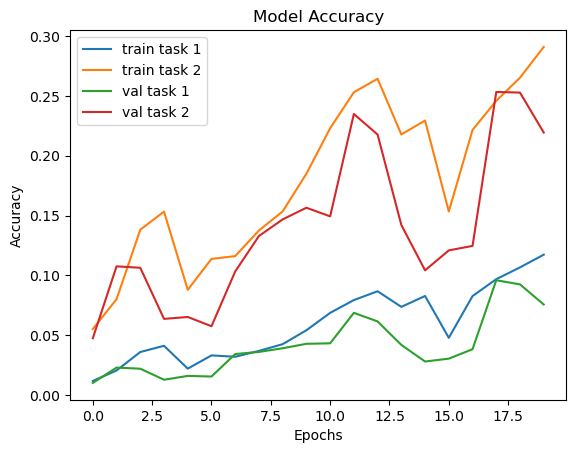

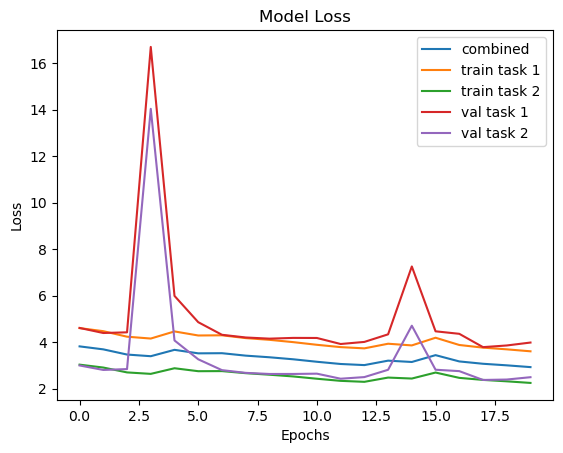

In [39]:
# accuracy plot
plt.plot(history_4.history['task_1_output_accuracy'])
plt.plot(history_4.history['task_2_output_accuracy'])
plt.plot(history_4.history['val_task_1_output_accuracy'])
plt.plot(history_4.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['task_1_output_loss'])
plt.plot(history_4.history['task_2_output_loss'])
plt.plot(history_4.history['val_task_1_output_loss'])
plt.plot(history_4.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.5. Case 5: Gamma = 0.5 - The model will receive loss evenly from task 1 and task 2.
##      (Dropout = 0.5, Optimizer = SGD)

In [40]:
# define parameters and generate model
gamma=0.5
dropout = 0.5
optimizer = 'SGD'
model_5 = create_model(dropout)

In [41]:
# compile model
model_5.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [42]:
# train model
history_5 = model_5.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 80s 206ms/step - loss: 3.8615 - task_1_output_loss: 4.6618 - task_2_output_loss: 3.0612 - task_1_output_accuracy: 0.0107 - task_2_output_accuracy: 0.0575 - val_loss: 134195984.0000 - val_task_1_output_loss: 149794672.0000 - val_task_2_output_loss: 118597296.0000 - val_task_1_output_accuracy: 0.0113 - val_task_2_output_accuracy: 0.0539
Epoch 2/20
167/167 [==============================] - 31s 188ms/step - loss: 3.8052 - task_1_output_loss: 4.6120 - task_2_output_loss: 2.9984 - task_1_output_accuracy: 0.0122 - task_2_output_accuracy: 0.0632 - val_loss: 16.4880 - val_task_1_output_loss: 17.3659 - val_task_2_output_loss: 15.6101 - val_task_1_output_accuracy: 0.0148 - val_task_2_output_accuracy: 0.0508
Epoch 3/20
167/167 [==============================] - 31s 188ms/step - loss: 3.7892 - task_1_output_loss: 4.5984 - task_2_output_loss: 2.9800 - task_1_output_accuracy: 0.0128 - task_2_output_accuracy: 0.0703 - val_loss: 23.4837 - val_task_

In [43]:
# train model results
print('Train loss:', history_5.history['loss'][-1])

print('\nTrain task 1 loss:', history_5.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_5.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_5.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_5.history['task_2_output_accuracy'][-1])

Train loss: 3.326611280441284

Train task 1 loss: 4.098245620727539
Train task 1 acc: 0.04557647183537483

Train task 2 loss: 2.554976224899292
Train task 2 acc: 0.17378823459148407


### Evaluate Model

In [44]:
# test model results
evaluation_results = model_5.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [45]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 3.7038519382476807

Test task 1 loss: 4.421416759490967
Test task 1 acc: 0.042899999767541885

Test task 2 loss: 2.9862875938415527
Test task 2 acc: 0.13529999554157257


### Plot Results

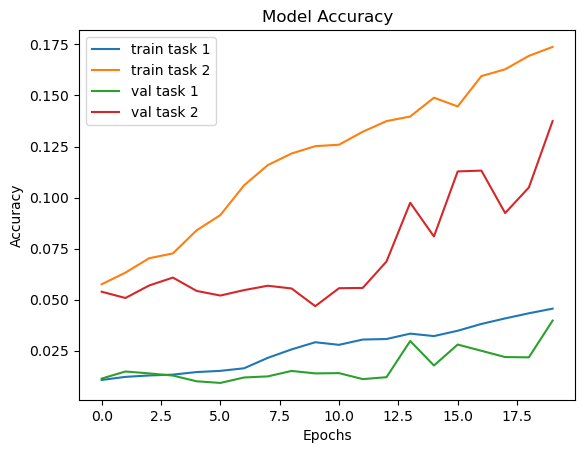

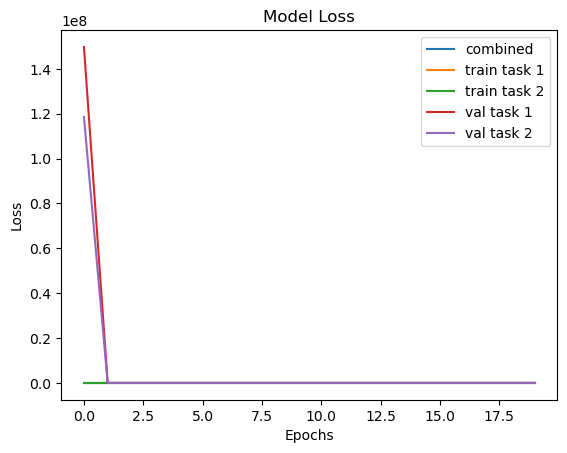

In [46]:
# accuracy plot
plt.plot(history_5.history['task_1_output_accuracy'])
plt.plot(history_5.history['task_2_output_accuracy'])
plt.plot(history_5.history['val_task_1_output_accuracy'])
plt.plot(history_5.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['task_1_output_loss'])
plt.plot(history_5.history['task_2_output_loss'])
plt.plot(history_5.history['val_task_1_output_loss'])
plt.plot(history_5.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.6. Case 6: Gamma = 1 - The model will receive the loss from task 1 only
##      (Dropout = 0, Optimizer = Adam)

In [47]:
# define parameters and generate model
gamma = 1
dropout = 0
optimizer = 'Adam'
model_6 = create_model(dropout)

In [48]:
# compile model
model_6.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [49]:
# train model
history_6 = model_6.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
167/167 [==============================] - 137s 214ms/step - loss: 4.5728 - task_1_output_loss: 4.5728 - task_2_output_loss: 3.2754 - task_1_output_accuracy: 0.0166 - task_2_output_accuracy: 0.0512 - val_loss: 4.6994 - val_task_1_output_loss: 4.6994 - val_task_2_output_loss: 3.0433 - val_task_1_output_accuracy: 0.0104 - val_task_2_output_accuracy: 0.0461
Epoch 2/20
167/167 [==============================] - 32s 191ms/step - loss: 4.2934 - task_1_output_loss: 4.2934 - task_2_output_loss: 3.1371 - task_1_output_accuracy: 0.0335 - task_2_output_accuracy: 0.0636 - val_loss: 4.6826 - val_task_1_output_loss: 4.6826 - val_task_2_output_loss: 3.3278 - val_task_1_output_accuracy: 0.0199 - val_task_2_output_accuracy: 0.0597
Epoch 3/20
167/167 [==============================] - 33s 197ms/step - loss: 4.1909 - task_1_output_loss: 4.1909 - task_2_output_loss: 3.1431 - task_1_output_accuracy: 0.0367 - task_2_output_accuracy: 0.0609 - val_loss: 4.9713 - val_task_1_output_loss: 4.9713 - val

In [50]:
# train model results
print('Train loss:', history_6.history['loss'][-1])

print('\nTrain task 1 loss:', history_6.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_6.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_6.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_6.history['task_2_output_accuracy'][-1])

Train loss: 2.8658504486083984

Train task 1 loss: 2.8658504486083984
Train task 1 acc: 0.24590587615966797

Train task 2 loss: 3.1806752681732178
Train task 2 acc: 0.01854117587208748


### Evaluate Model

In [51]:
# test model results
evaluation_results = model_6.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [52]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 3.553196907043457

Test task 1 loss: 3.553196907043457
Test task 1 acc: 0.18459999561309814

Test task 2 loss: 3.1563291549682617
Test task 2 acc: 0.025800000876188278


### Plot Results

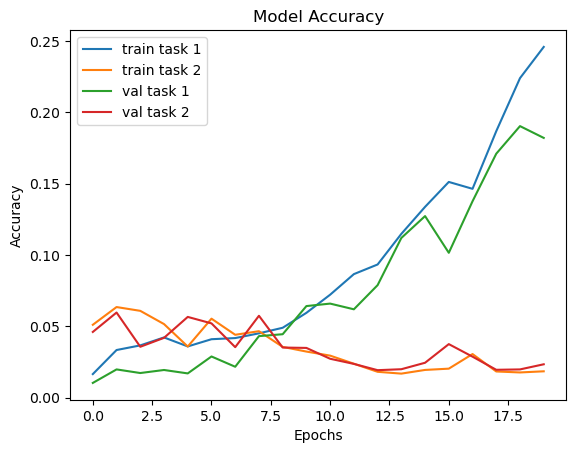

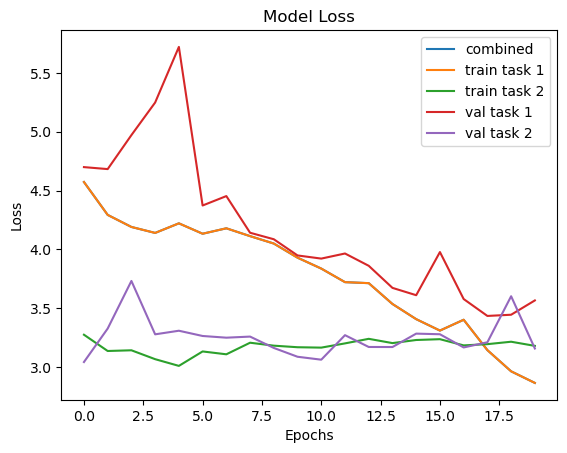

In [53]:
# accuracy plot
plt.plot(history_6.history['task_1_output_accuracy'])
plt.plot(history_6.history['task_2_output_accuracy'])
plt.plot(history_6.history['val_task_1_output_accuracy'])
plt.plot(history_6.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['task_1_output_loss'])
plt.plot(history_6.history['task_2_output_loss'])
plt.plot(history_6.history['val_task_1_output_loss'])
plt.plot(history_6.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()